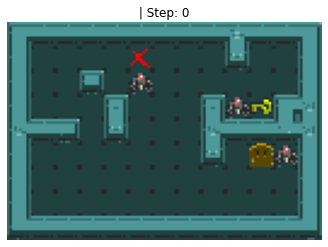

Action 1 played at game tick 488, reward=-1.0, new score=-1.0
Game over at game tick 488 with player PLAYER_LOSES


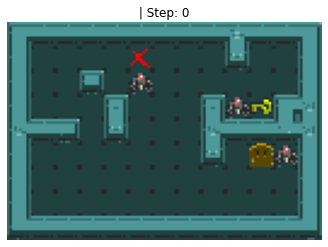

In [7]:
import gym
import gym_gvgai
import matplotlib.pyplot as plt
from IPython import display

env = gym.make('gvgai-zelda-lvl0-v0')
env.reset()


def show_state(env, step=0, name="", info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("{} | Step: {} {}".format(name, step, info))
    plt.axis("off")

    display.clear_output(wait=True)
    display.display(plt.gcf())

score = 0
for i in range(2000):
    action_id = env.action_space.sample()
    state, reward, isOver, info = env.step(action_id)
    score += reward
    show_state(env)
    print("Action " + str(action_id) + " played at game tick " + str(i+1) + ", reward=" + str(reward) + ", new score=" + str(score))
    if isOver:
        print("Game over at game tick " + str(i+1) + " with player " + info['winner'])
        break


In [ ]:
import random

import gym
import csv
import os
import gym_gvgai
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten

from enum import Enum
from collections import deque
from PIL import Image
from numpy import asarray

# Move to module


class Experience():
    def __init__(self, state, action, reward, next_state):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)


class ReplayMemory():
    def __init__(self, max_capacity):
        self.max_capacity = max_capacity
        self.memory = deque(maxlen=max_capacity)

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

    def __len__(self):
        return len(self.memory)

    def remember_experience(self, experience):
        if len(self.memory) == self.max_capacity:
            self.memory.pop()
        self.memory.append(experience)

    def get_batch(self, batchSize):
        if batchSize > len(self.memory):
            return random.sample(self.memory, len(self.memory))
        else:
            return random.sample(self.memory, batchSize)

# Move to module


class EpsilonStrategy():
    def __init__(self, initial_epsilon=1, min_epsilon=0.01, epsilon_decay_rate=0.001):
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

    def get_movement_strategy(self):
        random_number = random.uniform(0, 1)
        if self.epsilon > self.min_epsilon:
            self.epsilon -= self.epsilon_decay_rate
        if random_number > self.epsilon:
            return 'EXPLOIT'
        return 'EXPLORE'


# Utils / Constants
IMG_H = 9
IMG_W = 13


def show_state(env, step=0, name="", info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("{} | Step: {} {}".format(name, step, info))
    plt.axis("off")

    display.clear_output(wait=True)
    display.display(plt.gcf())


def show_loss_history(loss_history):
    plt.plot(loss_history)

    display.clear_output(wait=True)
    plt.show()


def grayToArray(array):
    result = np.zeros((IMG_H, IMG_W))
    for i in range(int(array.shape[0]/10)):
        for j in range(int(array.shape[1]/10)):
            result[i][j] = int(array[10*i+5, 10*j+5])
    return result


def grayConversion(image):
    b = image[..., 0]
    g = image[..., 1]
    r = image[..., 2]
    return 0.21 * r + 0.72 * g + 0.07 * b

# Hyperparameters


N_EPISODES = 20
N_TIMESTAMPS = 2000
N_INITIAL_POPULATION_TIMESTAMPS = 2500

MIN_REPLAY_MEMORY_SIZE = 10
EXPERIENCE_BATCH_SIZE = 100
MAX_REPLAY_MEMORY_SIZE = 200
STEPS_TO_UPDATE_NETWORK = 5
GAMMA = 0.9

# Agent


class Agent():

    def __init__(self):
        self.name = "Q-Learning agent"

        self.replay_memory = None
        self.policy_network = None
        self.target_network = None

        if os.path.exists("networks/policy_network"):
            print("Model loaded!")
            self.policy_network = keras.models.load_model(
                "networks/policy_network")
            print(self.policy_network.summary())
            self.target_network = keras.models.load_model(
                "networks/policy_network")

        self.movementStrategy = EpsilonStrategy()

    def _init_network(self, input_shape, n_outputs):
        inputs = Input(input_shape, name='state')
        x = Flatten()(inputs)
        x = Dense(30, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        outputs = Dense(n_outputs, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='game')

        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001))
        return model

    def _preprocess_state(self, raw_state):
        return grayToArray(grayConversion(raw_state))

    def _preprocess_reward(self, current_state, next_state, action_id, raw_reward, is_over, info):
        # This isn't a generic logic, it's exclusive for Zelda's levels
        actions_list = ['ACTION_NIL', 'ACTION_USE', 'ACTION_LEFT',
                        'ACTION_RIGHT', 'ACTION_DOWN', 'ACTION_UP']
        action = actions_list[action_id]

        is_winner = info["winner"] != "PLAYER_LOSES" and info["winner"] != "NO_WINNER"

        if is_over and is_winner:
            return 200

        if is_over and not is_winner:
            return -100

        if raw_reward > 0:
            return raw_reward * 10

        if action in ['ACTION_NIL']:
            return -100

        if action in ['ACTION_USE', 'ACTION_LEFT', 'ACTION_RIGHT', 'ACTION_DOWN', 'ACTION_UP']:
            return -5

    def train(self, env):
        # Models
        self.policy_network = self._init_network(
            (IMG_H, IMG_W), env.action_space.n)
        self.target_network = self._init_network(
            (IMG_H, IMG_W), env.action_space.n)

        # Replay memory
        self.replay_memory = ReplayMemory(MAX_REPLAY_MEMORY_SIZE)
        population_steps = 0

        # Metrics
        metrics = []
        loss_history = [0]

        for e in range(N_EPISODES):
            current_state = self._preprocess_state(env.reset())
            next_state = None
            sum_reward = 0

            for t in range(N_TIMESTAMPS):

                while population_steps < N_INITIAL_POPULATION_TIMESTAMPS:

                    # Take random action
                    action_id = env.action_space.sample()

                    # Emulate action
                    next_state, reward, is_over, debug = env.step(action_id)

                    # If the game is over while populating the replay memory we want to restart it
                    if is_over:
                        next_state = env.reset()

                    next_state = self._preprocess_state(next_state)
                    reward = self._preprocess_reward(
                        current_state, next_state, action_id, reward, is_over, debug)
                    sum_reward += reward

                    info = "action {0: <1}/{1: <15} | tick {2: <10} | reward {3: <5} | sum {4: <5} | is_over {5: <10} | status {6: <10}".format(
                        action_id, env.unwrapped.get_action_meanings()[action_id], t, reward, sum_reward, is_over, debug["winner"])

                    print("Populating replay memory: {}".format(info))

                    # Remember experience
                    experience = Experience(
                        current_state, action_id, reward, next_state)
                    self.replay_memory.remember_experience(experience)

                    population_steps += 1

                tensor_state = tf.convert_to_tensor([current_state])

                if self.movementStrategy.get_movement_strategy() == 'EXPLOIT':
                    q_values = self.policy_network.predict(tensor_state)
                    action_id = np.argmax(q_values[0])

                else:
                    action_id = env.action_space.sample()

                next_state, reward, is_over, debug = env.step(action_id)
                next_state = self._preprocess_state(next_state)
                reward = self._preprocess_reward(
                    current_state, next_state, action_id, reward, is_over, debug)
                sum_reward += reward

                info = "action {0: <1}/{1: <15} | tick {2: <10} | reward {3: <5} | sum {4: <5} | is_over {5: <10} | status {6: <10}".format(
                    action_id, env.unwrapped.get_action_meanings()[action_id], t, reward, sum_reward, is_over, debug["winner"])

                metrics.append([
                    action_id,
                    env.unwrapped.get_action_meanings()[action_id],
                    e,
                    t,
                    reward,
                    sum_reward,
                    is_over
                ])

                print(info)
                # show_state(env, t, "Zelda", info)
                # show_loss_history(loss_mean_history)

                if is_over:
                    break

                experience = Experience(
                    current_state, action_id, reward, next_state)
                self.replay_memory.remember_experience(experience)

                if len(self.replay_memory) > MIN_REPLAY_MEMORY_SIZE:
                    experiences_batch = self.replay_memory.get_batch(
                        EXPERIENCE_BATCH_SIZE)
                    for experience in experiences_batch:
                        tensor_state = tf.convert_to_tensor([experience.state])
                        tensor_next_state = tf.convert_to_tensor(
                            [experience.next_state])

                        policy_q_values = self.policy_network.predict(
                            tensor_state)
                        next_q_values = self.target_network.predict(
                            tensor_next_state)

                        policy_q_values[0][experience.action] = experience.reward + \
                            GAMMA * np.amax(next_q_values)

                        result = self.policy_network.fit(
                            tensor_state, policy_q_values, epochs=1, verbose=0)

                        loss = result.history['loss'][0]
                        loss_history.append(loss)

                current_state = next_state

                if t % STEPS_TO_UPDATE_NETWORK == 0:
                    self.target_network.set_weights(
                        self.policy_network.get_weights())

            self.save_model("policy_network_{}".format(e))
            np.savetxt("metrics_loss_history_{}.csv".format(e), loss_history, delimiter=",")

        np.savetxt("metrics_loss_history.csv", loss_history, delimiter=",")
        with open("metrics_metrics.csv", 'w') as csv_file:
            wr = csv.writer(csv_file, delimiter=',')
            for metric in metrics:
                wr.writerow(list(metric))

    def save_model(self, name="policy_network"):
        self.policy_network.save("networks/{}".format(name))

    def act(self, stateObs, actions):
        tensor_state = tf.convert_to_tensor([self._preprocess_state(stateObs)])
        q_values = self.policy_network.predict(tensor_state)
        action_id = np.argmax(q_values[0])
        return action_id


def train_agent(env, agent):
    agent.train(env)
    agent.save_model()


def play_agent(env, agent):
    stateObs = env.reset()
    actions = env.unwrapped.get_action_meanings()
    for t in range(5000):
        action_id = agent.act(stateObs, actions)
        stateObs, diffScore, done, debug = env.step(action_id)
        print("Action " + str(action_id) + " tick " + str(t+1) +
              " reward " + str(diffScore) + " win " + debug["winner"])
        if done:
            break


def main():
    zelda_env = gym.make("gvgai-zelda-lvl0-v0")
    agent = Agent()

    # train_agent(zelda_env, agent)
    play_agent(zelda_env, agent)


main()
